### **prep**

In [23]:
# importing packages 
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

In [24]:
# change to specific directory for user running code 
os.chdir("/Users/sophiekim/Desktop/research/MamalakisResearch") 
base_path = os.getcwd()

# everyone should have locally loaded 'data' folder
data_path = base_path + '/data/'

In [25]:
# initializing model list variable to call in function
model_list = [
    "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MIROC6_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MPI-ESM1-2-LR_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MRI-ESM2-0_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "UKESM1-0-LL_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
]

In [26]:
# pulling variables out for the plot function 
VAR_LIST = ["tas", "tasmax", "tasmin", "pr", "psl", "sfcWind", "mrsos"]

# dictionary for each unit for the plot 
UNIT_MAP = {
    "tas": "°C", 
    "tasmax": "°C", 
    "tasmin": "°C", 
    "pr": "mm/day", 
    "psl": "hPa", 
    "sfcWind": "m/s", 
    "mrsos": "kg/m²"}

### **functions**

In [ ]:
def convert_units(varname: str, x: np.ndarray):
    """
    varname: index number from the list of variables so get_data func can convert units 
    x: data that needs units changed (raw x data) in get_data func 
    """
    if varname in {"tas", "tasmax", "tasmin"}:
        # kelvin to celcius
        return x - 273.15, "$^{\circ}$C"
    if varname == "pr":
        # kg/m2/s to mm/day
        return x * 86400.0, "mm/day"
    if varname == "psl":
        # pascals to hpa
        return x / 100.0, "hPa"
    
    # these don't need to be converted -- just adding the units 
    if varname == "sfcWind":
        return x, "m/s"
    if varname == "mrsos":
        return x, "kg/m$^{2}$"
    return x, "unknown"

In [30]:
from netCDF4 import num2date

In [ ]:
def get_cnn_tensors(model_list, scenario, data_path, var_idx, 
                    st_early=2015, end_early=2024, 
                    st_late=2050, end_late=2059,
                    stat='mean', use_anomaly=True, 
                    base_start=2015, base_end=2024,
                    models_to_run=None, file_start_year=2015):
    """
    model_list: variable of list of models
    scenario: input as either 'ssp119' or 'ssp126' strings
    data_path: variable of data_path for user
    var_idx: 0-6 of the variable dimension of tensor 
        0: tas (near-surface air temp)
        1: tasmax (near-surface air temp max)
        2: tasmin (near-surface air temp min)
        3: pr (precipitation)
        4: psl (sea level pressure -- air pressure adjusted to sea level & drives weather patterns)
        5: sfcWind (surface wind speed -- usually 10m above land surface)
        6: mrsos (moisture in upper portion of soil col -- good for looking at agr & drought conditions)
    st_early: early period start yr integer
    end_early: early period end yr integer
    st_late: late period start yr integer
    end_late: late period end yr integer
    stat: what stat function user wants to run to summarize variables 
        mean: mean
        std: standard deviation
        max: max val
        min: min val
        medium: median
    use_anomaly: whether to subtract values from baseline values to find anomaly
        True: subtract values
        False: don't subtract values 
    base_start: baseline yr start
    base_end: baseline yr end 
    models_to_run: can specify number of models to run by index of model_list variable
        None: all models 
        [x]: one model to run 
        [x, x, x...]: whatever number of models to run 
    file_start_year: ensuring that if time dimension in models starts at 0 or 1, the func will slice the time correctly 
    """
    
    # indices in variable dimension to variable names 
    var_list = ["tas", "tasmax", "tasmin", "pr", "psl", "sfcWind", "mrsos"]
    # checking var_list for the specific variable index and if the var_idx input is bigger than 6, will give unknown 
    varname = var_list[var_idx] if var_idx < len(var_list) else "unknown"

    # making stat dictionary so stat input in func will do correct specified math 
    stat_map = {
        'mean': np.nanmean, 'std': np.nanstd, 
        'max': np.nanmax, 'min': np.nanmin, 'median': np.nanmedian
    }
    # variable that will calculate the stat for whatever the user wants and then will default to mean 
    calc_func = stat_map.get(stat.lower(), np.nanmean)

    # runs all models 
    if models_to_run is None:
        selected_models = model_list
    # runs one model if user only specified one 
    elif isinstance(models_to_run, int):
        selected_models = [model_list[models_to_run]]
    # if none of the above options (all or one) was selected, then was list of models so get those models 
    else:
        selected_models = [model_list[i] for i in models_to_run]

    # intilaizing x & y lists 
    x_list, y_list = [], []
    # if in early period, then 0; if in late period, then 1 
    periods = [(st_early, end_early, 0), (st_late, end_late, 1)]

    print(f"Variable: {varname} | Stat: {stat} | Anomaly: {use_anomaly}")

    # opening file 
    for filename in selected_models:
        full_path = os.path.join(data_path, filename)
        with nc.Dataset(full_path) as ds:
            # slicing data from models to get specific ssp scenario and for that variable 
                # so dimensions should be [ensemble, time, lat, lon]
            data_raw = ds[f"data_{scenario}"][:, var_idx, :, :, :]
            
            # calling convert_units func
            data, unit_str = convert_units(varname, data_raw)
            # Check the time metadata
            time_var = ds.variables['time']
            print(f"Time units in file: {time_var.units}")

            # Check the first time value
            first_month_val = time_var[0]
            print(f"First time index value: {first_month_val}")
            # if use_anomaly is true 
            if use_anomaly:
                # calculate start & end month index for baseline period 
                b_start, b_end = (base_start-file_start_year)*12, (base_end-file_start_year+1)*12
                # base variable values calculated for baseline period 
                ensemble_base = calc_func(data[:, b_start:b_end, :, :], axis=1)

            # looping through both early & late periods from the periods var 
            for start_yr, end_yr, label in periods:
                # looping thru each yr in the period 
                for yr_idx in range(start_yr, end_yr + 1):
                    
                    # getting month index values for a yr 
                    m_start = (yr_idx - file_start_year) * 12
                    m_end = m_start + 12
                    
                    # going thru each trajectory in model file
                    for ens_idx in range(5):
                        # slicing to isolate one trajectory for a yr and all lats/lons
                        annual_slice = data[ens_idx, m_start:m_end, :, :]
                        # calculating the values from stat input from user for every yr 
                        yearly_val = calc_func(annual_slice, axis=0)
                        
                        # if the use_anaomaly is true, then u subtract the yearly values from the baseline
                            # if use_anomaly is false, then val = yearly_val 
                        val = yearly_val - ensemble_base[ens_idx] if use_anomaly else yearly_val
                        
                        # adding vals to the x_list and the 0/1 for y_list 
                        x_list.append(val)
                        y_list.append(label)

    # adding everything all together 
        # np.expand_dims to make another dimension for the calculated values 
    x_data = np.expand_dims(np.array(x_list), axis=1) 
    # adding the 0/1 values and reshaping for a 500,1 shape 
    y_data = np.array(y_list).reshape(-1, 1)
    
    # replacing the NAs to 0s in x_data 
    return np.nan_to_num(x_data, nan=0.0), y_data

In [ ]:
# initializing var_list
VAR_LIST = ["tas", "tasmax", "tasmin", "pr", "psl", "sfcWind", "mrsos"]

# initalizing unit dictionary 
UNIT_MAP = {
    "tas": "°C", 
    "tasmax": "°C", 
    "tasmin": "°C", 
    "pr": "mm/day", 
    "psl": "hPa", 
    "sfcWind": "m/s", 
    "mrsos": "kg/m²"}

In [ ]:
def plot_period_comparison(x_data, y_data, var_idx):
    # getting variable name for index input 
    var_name = VAR_LIST[var_idx]
    # finding unit for the variable
    units = UNIT_MAP.get(var_name, "units")
    
    # looking for the early and late indices in y_data and returns list of row numbers with early and late period indices 
    early_indices = np.where(y_data == 0)[0]
    late_indices = np.where(y_data == 1)[0]
    
    # calculating the mean values across all years 
    early_mean = np.mean(x_data[early_indices], axis=0)[0]
    late_mean = np.mean(x_data[late_indices], axis=0)[0]
    signal = late_mean - early_mean
    

    # 3 plots on one row 
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    titles = [f"Mean Early ({var_name})", f"Mean Late ({var_name})", "The Signal (Late - Early)"]
    # transpose so map looks good (would be flipped otherwise)
    maps = [early_mean.T, late_mean.T, signal.T]
    
    # looping three times for each map 
    for i in range(3):
        # if map is for the early/late periods
        if i < 2:
            # get mins and maxes for color bar
            vmin, vmax = np.nanmin(maps[i]), np.nanmax(maps[i])
            cmap = 'cool' # specifying a seqeuntial colormap bc i think it looks better? 
        else:
            # making signal plot around zero by making everything absolute value and then finds max (skiping na values)
            sig_limit = np.nanmax(np.abs(signal))
            # in case signal is 0 (which would crash code), change to 0.1 so that at least everything runs 
            if sig_limit == 0: sig_limit = 0.1 
            # min and max for color bar (all around 0)
            vmin, vmax = -sig_limit, sig_limit
            cmap = 'RdBu' # specifying diverging colormap 
        
        im = axes[i].imshow(maps[i], origin='lower', cmap=cmap, 
                            vmin=vmin, vmax=vmax, aspect='auto')
        
        axes[i].set_title(titles[i])
        plt.colorbar(im, ax=axes[i], label=f"{var_name} ({units})")
        axes[i].set_xlabel("Longitude Index")
        axes[i].set_ylabel("Latitude Index")

    plt.tight_layout()
    plt.show()

 for diverging color maps: 
- https://matplotlib.org/3.1.3/gallery/color/colormap_reference.html 

for sequential color maps: 
- https://matplotlib.org/stable/users/explain/colors/colormaps.html
- https://matplotlib.org/stable/users/explain/colors/colormaps.html


In [40]:
x_train, y_train = get_cnn_tensors(model_list, 'ssp119', data_path, var_idx=3, use_anomaly=False)

Variable: pr | Stat: mean | Anomaly: False
Time units in file: months
First time index value: 1.0


/var/folders/v1/c8q_17915_v735dr_k_2fb7w0000gn/T/ipykernel_19273/4279789748.py:105: RuntimeWarning: Mean of empty slice
  yearly_val = calc_func(annual_slice, axis=0)


Time units in file: months
First time index value: 1.0
Time units in file: months
First time index value: 1.0
Time units in file: months
First time index value: 1.0
Time units in file: months
First time index value: 1.0


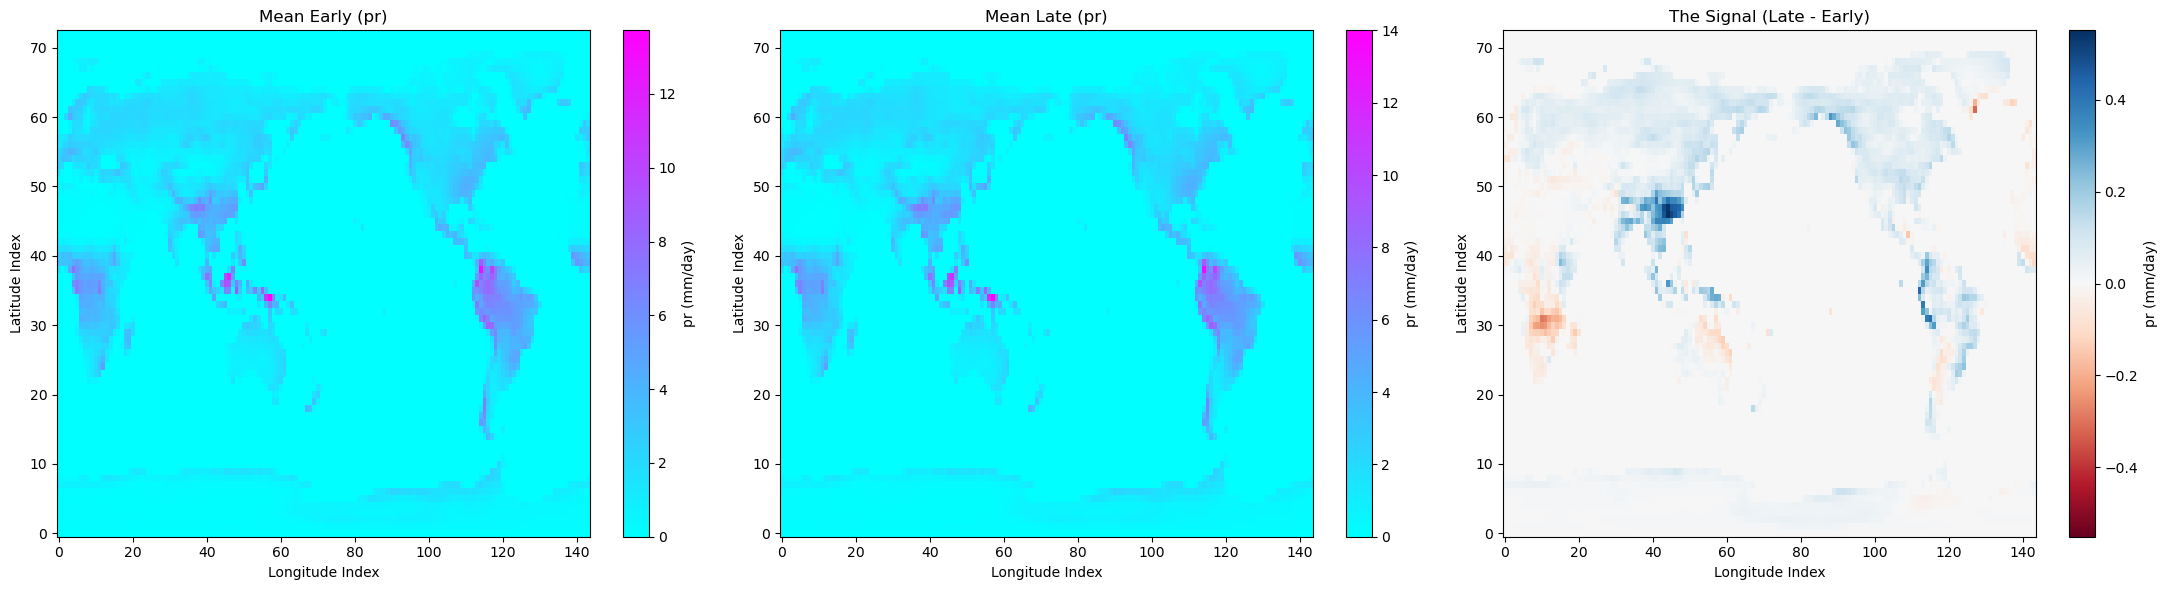

In [57]:
plot_period_comparison(x_train, y_train, var_idx=3)